In [28]:
import os, sys, gzip
import numpy as np
from six.moves import cPickle
sys.setrecursionlimit(10000)

from lasagne import layers, nonlinearities, updates, objectives, init, regularization
from lasagne.layers import get_output, get_output_shape, get_all_params
import theano.tensor as T
import theano
from theano.tensor.shared_randomstreams import RandomStreams
from lasagne.layers import Conv2DLayer, DenseLayer, InputLayer, ExpressionLayer, BiasLayer
from lasagne.layers import NonlinearityLayer, MaxPool2DLayer, DropoutLayer, BatchNormLayer
from lasagne.layers import InverseLayer
sys.path.append('..')
from src import NeuralNet
from src import train as fit
from src import make_directory 
from models import load_model
from data import load_data

np.random.seed(247) # for reproducibility

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
%matplotlib inline
from scipy.misc import imresize

In [2]:
filename = 'Localized_N=100000_S=200_M=50_G=20_data.pickle'
datapath = '/home/peter/Data/SequenceMotif'
filepath = os.path.join(datapath, filename)

# load training set
print "loading data from: " + filepath
f = open(filepath, 'rb')
print "loading train data"
train = cPickle.load(f)
print "loading cross-validation data"
cross_validation = cPickle.load(f)
print "loading test data"
test = cPickle.load(f)
f.close()

X_train = train[0].transpose((0,1,2)).astype(np.float32)
y_train = train[1].astype(np.int32)
X_val = cross_validation[0].transpose((0,1,2)).astype(np.float32)
y_val = cross_validation[1].astype(np.int32)
X_test = test[0].transpose((0,1,2)).astype(np.float32)
y_test = test[1].astype(np.int32)

X_train = np.expand_dims(X_train, axis=3)
X_val = np.expand_dims(X_val, axis=3)
X_test = np.expand_dims(X_test, axis=3)

train = (X_train, y_train, train[2])
valid = (X_val, y_val, cross_validation[2])
test = (X_test, y_test, test[2])

shape = (None, train[0].shape[1], train[0].shape[2], train[0].shape[3])
num_labels = train[1].shape[1]

loading data from: /home/peter/Data/SequenceMotif/Localized_N=100000_S=200_M=50_G=20_data.pickle
loading train data
loading cross-validation data
loading test data


In [37]:
input_var1 = T.tensor4('inputs')
net1 = {}
net1['input'] = InputLayer(tuple(shape), input_var=input_var1)
net1['conv1']  = Conv2DLayer(net1['input'], num_filters=30,
                                          filter_size=(11,1),
                                          W=init.GlorotUniform(),
                                          b=None, 
                                          pad='same',
                                          nonlinearity=None, flip_filters=False)
net1['conv1_bias'] = BiasLayer(net1['conv1'], b=init.Constant(.05))
#net1['conv1_norm'] = BatchNormLayer(net1['conv1_bias'])
#net1['conv1_norm'] = layers.LocalResponseNormalization2DLayer(net1['conv1_bias'])
net1['conv1_active'] = NonlinearityLayer(net1['conv1_bias'], nonlinearity=nonlinearities.rectify)
net1['conv1_pool'] = MaxPool2DLayer(net1['conv1_active'], pool_size=(4,1))

net1['dense'] = DenseLayer(net1['conv1_pool'], num_units=20, W=init.GlorotUniform(), 
                                     b=None, nonlinearity=None)
net1['dense_bias'] = BiasLayer(net1['dense'], b=init.Constant(0.05))
net1['dense_active'] = NonlinearityLayer(net1['dense_bias'], nonlinearity=nonlinearities.sigmoid)
net1['output'] = net1['dense_active']


In [38]:
target_var = T.dmatrix('targets')
prediction = layers.get_output(net1['output'], deterministic=False)

loss = objectives.binary_crossentropy(prediction, target_var)
loss = objectives.aggregate(loss)
    
params = layers.get_all_params(net1['output'], trainable=True)    
grad = T.grad(loss, params)
update_op = updates.adam(grad, params, learning_rate=0.001)
train_fun = theano.function([input_var1, target_var], [loss, prediction], updates=update_op)
test_fun = theano.function([input_var1, target_var], [loss, prediction])


In [39]:
def batch_generator(X, y, batch_size=128):
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype(np.float32), y[excerpt].astype(np.float32)

status = True
patience = 5
min_loss = 1e10
epoch = 0
min_epoch = 0
while status:
    sys.stdout.write("\rEpoch %d \n"%(epoch+1))

    batch_size = 128        
    num_batches = train[0].shape[0] // batch_size
    train_batches = batch_generator(train[0], train[1], batch_size)
    value = 0
    for i in range(num_batches):
        X,y = next(train_batches)
        loss, prediction = train_fun(X, y)
        value += np.mean(loss)
    sys.stdout.write("\r  train loss = %f \n"%(value/num_batches))
    
    num_batches = valid[0].shape[0] // batch_size
    valid_batches = batch_generator(valid[0], valid[1], batch_size)
    value = 0
    for i in range(num_batches):
        X,y = next(valid_batches)
        loss, prediction = test_fun(X, y)
        value += np.mean(loss)
    sys.stdout.write("\r  valid loss = %f \n"%(value/num_batches))
    
    if value < min_loss:
        min_loss = value
        min_epoch = epoch
    else:
        if patience - (epoch - min_epoch) == 0:
            status = False
            print "Patience ran out... Early stopping."
    epoch += 1
    if epoch == 50:
        status = False
    

Epoch 1 
  train loss = 0.121894 
  valid loss = 0.051667 
Epoch 2 
  train loss = 0.036025 
  valid loss = 0.026939 
Epoch 3 
  train loss = 0.022455 
  valid loss = 0.020389 
Epoch 4 
  train loss = 0.017561 
  valid loss = 0.017704 
Epoch 5 
  train loss = 0.014970 
  valid loss = 0.016474 
Epoch 6 
  train loss = 0.013296 
  valid loss = 0.015883 
Epoch 7 
  train loss = 0.012088 
  valid loss = 0.015575 
Epoch 8 
  train loss = 0.011153 
  valid loss = 0.015285 
Epoch 9 
  train loss = 0.010391 
  valid loss = 0.015025 
Epoch 10 
  train loss = 0.009752 
  valid loss = 0.014840 
Epoch 11 
  train loss = 0.009199 
  valid loss = 0.014767 
Epoch 12 
  train loss = 0.008716 
  valid loss = 0.014831 
Epoch 13 
  train loss = 0.008297 
  valid loss = 0.014980 
Epoch 14 
  train loss = 0.007931 
  valid loss = 0.015164 
Epoch 15 
  train loss = 0.007605 
  valid loss = 0.015374 
Epoch 16 
  train loss = 0.007312 
  valid loss = 0.015610 
Patience ran out... Early stopping.


In [40]:
prediction2 = layers.get_output(net1['output'], deterministic=True)
loss = -(target_var*T.log(prediction2) + (1.0-target_var)*T.log(1.0-prediction2))
loss = loss.mean()
test_fun = theano.function([input_var1, target_var], [loss, prediction2])

num_batches = test[0].shape[0] // batch_size
valid_batches = batch_generator(test[0], test[1], batch_size)
value = 0
accuracy = 0
for i in range(num_batches):
    X,y = next(valid_batches)
    loss, prediction = test_fun(X, y)
    value += np.mean(loss)
    accuracy += float(np.sum(np.argmax(prediction,axis=1) == np.argmax(y,axis=1)))/batch_size
sys.stdout.write("\r  test loss = %f \n"%(value/num_batches))
sys.stdout.write("\r  test accuracy = %f \n"%(accuracy/num_batches))

  test loss = 0.016036 
  test accuracy = 0.977564 


In [41]:
import pandas as pd
def seq_logo(pwm, height=100, nt_width=20, norm=0, rna=1, filepath='.'):
    """generate a sequence logo from a pwm"""
    
    def load_alphabet(filepath, rna):
        """load images of nucleotide alphabet """
        df = pd.read_table(os.path.join(filepath, 'A.txt'), header=None);
        A_img = df.as_matrix()
        A_img = np.reshape(A_img, [72, 65, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'C.txt'), header=None);
        C_img = df.as_matrix()
        C_img = np.reshape(C_img, [76, 64, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'G.txt'), header=None);
        G_img = df.as_matrix()
        G_img = np.reshape(G_img, [76, 67, 3], order="F").astype(np.uint8)

        if rna == 1:
            df = pd.read_table(os.path.join(filepath, 'U.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [74, 57, 3], order="F").astype(np.uint8)
        else:
            df = pd.read_table(os.path.join(filepath, 'T.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [72, 59, 3], order="F").astype(np.uint8)

        return A_img, C_img, G_img, T_img


    def get_nt_height(pwm, height, norm):
        """get the heights of each nucleotide"""

        def entropy(p):
            """calculate entropy of each nucleotide"""
            s = 0
            for i in range(4):
                if p[i] > 0:
                    s -= p[i]*np.log2(p[i])
            return s

        num_nt, num_seq = pwm.shape
        heights = np.zeros((num_nt,num_seq));
        for i in range(num_seq):
            if norm == 1:
                total_height = height
            else:
                total_height = (np.log2(4) - entropy(pwm[:, i]))*height;
            heights[:,i] = np.floor(pwm[:,i]*total_height);
        return heights.astype(int)

    
    # get the alphabet images of each nucleotide
    A_img, C_img, G_img, T_img = load_alphabet(filepath='.', rna=1)
    
    
    # get the heights of each nucleotide
    heights = get_nt_height(pwm, height, norm)
    
    # resize nucleotide images for each base of sequence and stack
    num_nt, num_seq = pwm.shape
    width = np.ceil(nt_width*num_seq).astype(int)
    
    total_height = np.sum(heights,axis=0)
    max_height = np.max(total_height)
    logo = np.ones((height*2, width, 3)).astype(int)*255;
    for i in range(num_seq):
        remaining_height = total_height[i];
        offset = max_height-remaining_height
        nt_height = np.sort(heights[:,i]);
        index = np.argsort(heights[:,i])

        for j in range(num_nt):
            if nt_height[j] > 0:
                # resized dimensions of image
                resize = (nt_height[j], nt_width)
                if index[j] == 0:
                    nt_img = imresize(A_img, resize)
                elif index[j] == 1:
                    nt_img = imresize(C_img, resize)
                elif index[j] == 2:
                    nt_img = imresize(G_img, resize)
                elif index[j] == 3:
                    nt_img = imresize(T_img, resize)

                # determine location of image
                height_range = range(remaining_height-nt_height[j], remaining_height)
                width_range = range(i*nt_width, i*nt_width+nt_width)

                # 'annoying' way to broadcast resized nucleotide image
                if height_range:
                    for k in range(3):
                        for m in range(len(width_range)):
                            logo[height_range+offset, width_range[m],k] = nt_img[:,m,k];

                remaining_height -= nt_height[j]

    return logo.astype(np.uint8)


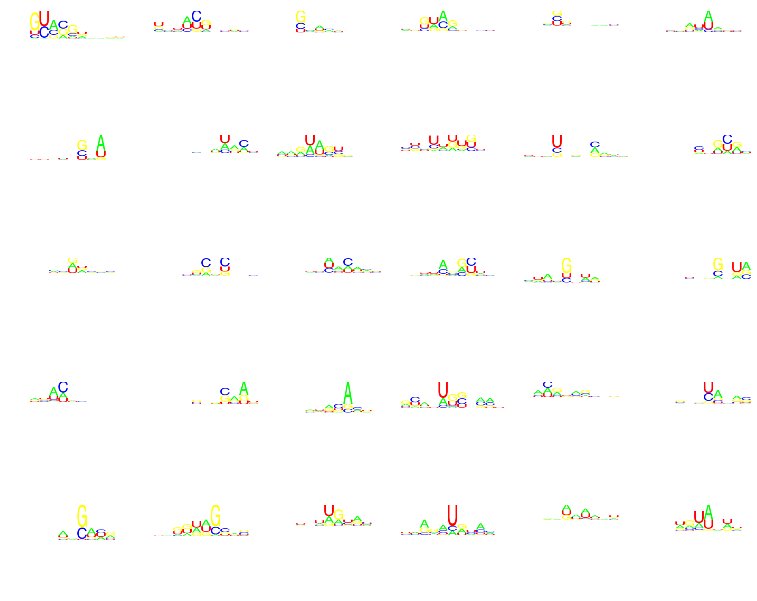

In [42]:
def plot_conv_filter(layer,size):
    W =  np.squeeze(layer.W.get_value())
    num_filters = W.shape[0]

    num_rows = int(np.ceil(np.sqrt(num_filters)))    
    grid = mpl.gridspec.GridSpec(num_rows, num_rows)
    grid.update(wspace=0.2, hspace=0.2, left=0.1, right=0.2, bottom=0.1, top=0.2) 
    
    fig = plt.figure(figsize=size);
    for i in range(num_filters):
        MIN = np.min(W[i])
        MAX = np.max(W[i])
        pwm = (W[i] - MIN)#/(MAX-MIN)
        norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
        pwm = pwm/norm

        logo = seq_logo(pwm, height=100, nt_width=25, norm=0, rna=1, filepath='.')
        plt.subplot(grid[i]);
        plt.imshow(logo);
        plt.axis('off');
    return fig, plt

fig, plt = plot_conv_filter(net1['conv1'],size=(100.,100.))
fig.set_size_inches(100,100)

In [44]:
X = test[0]
layer = net1['conv1_pool']

# setup theano function to get feature map of a given layer
num_data = len(X)
feature_maps = theano.function([input_var1], layers.get_output(layer), allow_input_downcast=True)
map_shape = get_output_shape(layer)

# get feature maps in batches for speed (large batches may be too much memory for GPU)
num_batches = num_data // batch_size
shape = list(map_shape)
shape[0] = num_data
fmaps = np.empty(tuple(shape))
for i in range(num_batches):
    index = range(i*batch_size, (i+1)*batch_size)    
    fmaps[index] = feature_maps(X[index])

# get the rest of the feature maps
excess = num_data-num_batches*batch_size
index = range(num_data-excess, num_data)    
fmaps[index] = feature_maps(X[index])


In [47]:
active = np.squeeze(fmaps.shape)

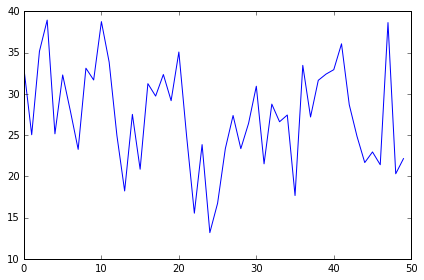

In [61]:
plt.figure()
plt.plot(np.sum(np.squeeze(fmaps[0]),axis=0));

(30, 50)

In [ ]:
input_var1 = T.tensor4('inputs')
net1 = {}
net1['input'] = InputLayer(tuple(shape), input_var=input_var1)
deconv['conv1']  = Conv2DLayer(deconv['input'], num_filters=64,
                                          filter_size=(11,1),
                                          W=network['conv1'].W,
                                          b=None, 
                                          pad='same',
                                          nonlinearity=None, flip_filters=False)
deconv['conv1_bias'] = BiasLayer(deconv['conv1'], b=network['conv1_bias'].b)
deconv['conv1_norm'] = BatchNormLayer(deconv['conv1_bias'], beta=network['conv1_batch'].beta, 
                                                            gamma=network['conv1_batch'].gamma, 
                                                            mean=network['conv1_batch'].mean, 
                                                            inv_std=network['conv1_batch'].inv_std)
deconv['conv1'].params[deconv['conv1'].W].remove('trainable')
deconv['conv1_bias'].params[deconv['conv1_bias'].b].remove('trainable')
deconv['conv1_norm'].params[deconv['conv1_norm'].beta].remove('trainable')
deconv['conv1_norm'].params[deconv['conv1_norm'].gamma].remove('trainable')

deconv['conv1_active'] = NonlinearityLayer(deconv['conv1_norm'], nonlinearity=nonlinearities.rectify)
#deconv['conv1_active'] = layers.ParametricRectifierLayer(deconv['conv1_norm'], alpha=init.Constant(0.25))
deconv['conv1_pool'] = MaxPool2DLayer(deconv['conv1_active'], pool_size=(4,1))


deconv['conv2']  = Conv2DLayer(deconv['conv1_pool'], num_filters=128,
                                          filter_size=(7,1),
                                          W=network['conv2'].W,
                                          b=None, 
                                          pad='same',
                                          nonlinearity=nonlinearities.rectify, flip_filters=False)
deconv['conv2_bias'] = BiasLayer(deconv['conv2'], b=network['conv2_bias'].b)
deconv['conv2_norm'] = BatchNormLayer(deconv['conv2_bias'], beta=network['conv2_batch'].beta, 
                                                            gamma=network['conv2_batch'].gamma, 
                                                            mean=network['conv2_batch'].mean, 
                                                            inv_std=network['conv2_batch'].inv_std)
deconv['conv2_active'] = NonlinearityLayer(deconv['conv2_norm'], nonlinearity=nonlinearities.rectify)
#deconv['conv2_active'] = layers.ParametricRectifierLayer(deconv['conv2_norm'], alpha=init.Constant(0.25))
deconv['conv2_pool'] = MaxPool2DLayer(deconv['conv2_active'], pool_size=(2,1))
deconv['conv2'].params[deconv['conv2'].W].remove('trainable')
deconv['conv2_bias'].params[deconv['conv2_bias'].b].remove('trainable')
deconv['conv2_norm'].params[deconv['conv2_norm'].beta].remove('trainable')
deconv['conv2_norm'].params[deconv['conv2_norm'].gamma].remove('trainable')


deconv['conv3']  = Conv2DLayer(deconv['conv2_pool'], num_filters=256,
                                          filter_size=(5,1),
                                          W=network['conv3'].W,
                                          b=None, 
                                          pad='same',
                                          nonlinearity=None, flip_filters=False)
deconv['conv3_bias'] = BiasLayer(deconv['conv3'], b=network['conv3_bias'].b)
deconv['conv3_norm'] = BatchNormLayer(deconv['conv3_bias'], beta=network['conv3_batch'].beta, 
                                                            gamma=network['conv3_batch'].gamma, 
                                                            mean=network['conv3_batch'].mean, 
                                                            inv_std=network['conv3_batch'].inv_std)
deconv['conv3_active'] = NonlinearityLayer(deconv['conv3_norm'], nonlinearity=nonlinearities.rectify)
deconv['conv3_pool'] = MaxPool2DLayer(deconv['conv3_active'], pool_size=(5,1))
deconv['conv3'].params[deconv['conv3'].W].remove('trainable')
deconv['conv3_bias'].params[deconv['conv3_bias'].b].remove('trainable')
deconv['conv3_norm'].params[deconv['conv3_norm'].beta].remove('trainable')
deconv['conv3_norm'].params[deconv['conv3_norm'].gamma].remove('trainable')


deconv['conv4']  = Conv2DLayer(deconv['conv3_pool'], num_filters=512,
                                          filter_size=(5,1),
                                          W=network['conv4'].W,
                                          b=None, 
                                          pad='same',
                                          nonlinearity=None, flip_filters=False)
deconv['conv4_bias'] = BiasLayer(deconv['conv4'], b=network['conv4_bias'].b)
deconv['conv4_norm'] = BatchNormLayer(deconv['conv4_bias'], beta=network['conv4_batch'].beta, 
                                                            gamma=network['conv4_batch'].gamma, 
                                                            mean=network['conv4_batch'].mean, 
                                                            inv_std=network['conv4_batch'].inv_std)
deconv['conv4_active'] = NonlinearityLayer(deconv['conv4_norm'], nonlinearity=nonlinearities.rectify)
deconv['conv4_pool'] = MaxPool2DLayer(deconv['conv4_active'], pool_size=(5,1))
deconv['conv4'].params[deconv['conv4'].W].remove('trainable')
deconv['conv4_bias'].params[deconv['conv4_bias'].b].remove('trainable')
deconv['conv4_norm'].params[deconv['conv4_norm'].beta].remove('trainable')
deconv['conv4_norm'].params[deconv['conv4_norm'].gamma].remove('trainable')

deconv['dense'] = DenseLayer(deconv['conv4_pool'], num_units=20, W=network['dense'].W, 
                                     b=None, nonlinearity=None)
deconv['dense_bias'] = BiasLayer(deconv['dense'], b=network['dense_bias'].b)
deconv['dense_active'] = NonlinearityLayer(deconv['dense_bias'], nonlinearity=nonlinearities.sigmoid)
deconv['dense'].params[deconv['dense'].W].remove('trainable')
deconv['dense_bias'].params[deconv['dense_bias'].b].remove('trainable')

deconv['encode'] = NonlinearityLayer(deconv['dense_active'], nonlinearity=None)

#==============================================================================================\
# decode

num_units = np.prod(list(get_output_shape(network['conv4_pool']))[1:])

#deconv['invdense_bias'] = BiasLayer(deconv['encode'],b=-network['dense_bias'].b)
deconv['invdense'] = DenseLayer(deconv['encode'], num_units=num_units, W=network['dense'].W.dimshuffle([1,0]), 
                                     b=init.Constant(0.05), nonlinearity=None)
deconv['invdense'].params[deconv['invdense'].W].remove('trainable')
deconv['invdense_active'] = NonlinearityLayer(deconv['invdense'], nonlinearity=nonlinearities.rectify)


shape2 = list(get_output_shape(deconv['conv4_pool']))
shape2[0] = -1
deconv['reshape'] = layers.ReshapeLayer(deconv['invdense_active'], shape=tuple(shape2))

#deconv['invconv4_pool'] = InverseLayer(deconv['reshape'], deconv['conv4_pool'])
deconv['invconv4_pool'] = layers.Upscale2DLayer(deconv['reshape'], (5,1))
#deconv['invconv4_bias'] = BiasLayer(deconv['invconv4_pool'],b=-network['conv4_bias'].b)
deconv['invconv4']  = Conv2DLayer(deconv['invconv4_pool'], num_filters=network['conv4'].input_shape[1],
                                          filter_size=network['conv4'].filter_size,
                                          W=network['conv4'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=None, flip_filters=True)
deconv['invconv4'].params[deconv['invconv4'].W].remove('trainable')
#deconv['invconv4_norm'] = BatchNormLayer(deconv['invconv4'])
deconv['invconv4_active'] = NonlinearityLayer(deconv['invconv4'], nonlinearity=nonlinearities.rectify)


#deconv['invconv3_pool'] = InverseLayer(deconv['invconv4_active'], deconv['conv3_pool'])
deconv['invconv3_pool'] = layers.Upscale2DLayer(deconv['invconv4_active'], (5,1))
#deconv['invconv3_bias'] = BiasLayer(deconv['invconv3_pool'],b=-network['conv3_bias'].b)
deconv['invconv3']  = Conv2DLayer(deconv['invconv3_pool'], num_filters=network['conv3'].input_shape[1],
                                          filter_size=network['conv3'].filter_size,
                                          W=network['conv3'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=None, flip_filters=True)
deconv['invconv3'].params[deconv['invconv3'].W].remove('trainable')
#deconv['invconv3_norm'] = BatchNormLayer(deconv['invconv3'])
deconv['invconv3_active'] = NonlinearityLayer(deconv['invconv3'], nonlinearity=nonlinearities.rectify)



#deconv['invconv2_pool'] = InverseLayer(deconv['invconv3_active'], deconv['conv2_pool'])
deconv['invconv2_pool'] = layers.Upscale2DLayer(deconv['invconv3_active'], (2,1))
#deconv['invconv2_bias'] = BiasLayer(deconv['invconv2_pool'],b=-network['conv2_bias'].b)
deconv['invconv2']  = Conv2DLayer(deconv['invconv2_pool'], num_filters=network['conv2'].input_shape[1],
                                          filter_size=network['conv2'].filter_size,
                                          W=network['conv2'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=nonlinearities.rectify, flip_filters=True)
deconv['invconv2'].params[deconv['invconv2'].W].remove('trainable')
#deconv['invconv2_norm'] = BatchNormLayer(deconv['invconv2'])
deconv['invconv2_active'] = NonlinearityLayer(deconv['invconv2'], nonlinearity=nonlinearities.rectify)

#deconv['invconv1_pool'] = InverseLayer(deconv['invconv2_active'], deconv['conv1_pool'])
deconv['invconv1_pool'] = layers.Upscale2DLayer(deconv['invconv2_active'], (4,1))
#deconv['invconv1_bias'] = BiasLayer(deconv['invconv1_pool'],b=-network['conv1_bias'].b)
deconv['invconv1']  = Conv2DLayer(deconv['invconv1_pool'], num_filters=network['conv1'].input_shape[1],
                                          filter_size=network['conv1'].filter_size,
                                          W=network['conv1'].W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=init.Constant(0.05), 
                                          pad='same',
                                          nonlinearity=nonlinearities.sigmoid, flip_filters=True)
deconv['invconv1'].params[deconv['invconv1'].W].remove('trainable')
deconv['output'] = deconv['invconv1']
